<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Gillespie_final_comparition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
import networkx as nx
def Gillespie_Direct_Method_Non_Markovian_Network(N,X_I_indexes,params=[],densities=[],survivals=[],G_network_initial=nx.Graph(),approx=False,approx_lim=0.1,T=np.inf):
### Algoritmo------------------------------
    if(len(params)>0):
        a_I,a_R,lammbda_I,lammbda_R=params#
        def psi_survival_infection(x):
            return np.exp(-(lammbda_I*x)**(a_I))
        def psi_survival_recovery(x):
            return np.exp(-(lammbda_R*x)**(a_R))
        def psi_infection(x):
            return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
        def psi_recovery(x):
            return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
        general=False
    else:
        psi_infection = lambda x:densities[0](x)
        psi_recovery = lambda x:densities[1](x)
        psi_survival_infection = lambda x:survivals[0](x)
        psi_survival_recovery = lambda x:survivals[1](x)
        general=True
    pos=nx.spring_layout(G_network_initial,seed=2,k=3)
    #---------------------------
#Paso 1.
    t=0
    aristas_en_riesgo={'arista':[],'tiempo':[]}
    vertices_infecciosos={'vertice':[],'tiempo':[]}
    #Llenar estos arreglos.
    #N es el número de individuos.
    for j in X_I_indexes:
        vertices_infecciosos['vertice'].append(j)
        vertices_infecciosos['tiempo'].append(0)
        for i in range(N):
            if G_network_initial.has_edge(i,j):
                aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))
                aristas_en_riesgo['tiempo'].append(0)
    flag=True
#---------------------------
    hist=[]
    tau=0.5
    X_I=len(X_I_indexes)
    X_S=N-X_I
    X_R=0
    while(X_I>0 and flag):
        #Paso 2.
        #Definir Phi(tau|{t_j}):
        #---------------------------
        #Paso 3.
        #Generar el tiempo de siguiente reaccion:
        u=np.random.uniform()
        if (not general):
            def f_to_solve(x):
                S_1=np.sum([(x+r)**(a_I) for r in aristas_en_riesgo['tiempo']])
                S_2=np.sum([(x+r)**(a_R) for r in vertices_infecciosos['tiempo']])
                S_3=np.sum([r**a_I for r in aristas_en_riesgo['tiempo']])
                S_4=np.sum([r**a_R for r in vertices_infecciosos['tiempo']])
                return ((lammbda_I**(a_I))*(S_1-S_3)+(lammbda_R**(a_R))*(S_2-S_4)+np.log(u))
            def f_to_solve_prime(x):
                S_1=a_I*np.sum([(x+r)**(a_I-1) for r in aristas_en_riesgo['tiempo']])
                S_2=a_R*np.sum([(x+r)**(a_R-1) for r in vertices_infecciosos['tiempo']])
                return (a_I*(lammbda_I**(a_I))*S_1+a_R*(lammbda_R**(a_R))*S_2)
            try:
                tau=newton(func=f_to_solve,x0=tau,fprime=f_to_solve_prime)
            except:
                print("Error in Newton")
                break
        else:
            def f_to_solve_general(x):
                S_1=np.sum([np.log(psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
                S_2=np.sum([np.log(psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
                S_3=np.sum([np.log(psi_survival_infection(r)) for r in aristas_en_riesgo['tiempo']])
                S_4=np.sum([np.log(psi_survival_recovery(r)) for r in vertices_infecciosos['tiempo']])
                return (S_1+S_2-S_3-S_4-np.log(u))
            def f_to_solve_general_prime(x):
                S_1=np.sum([(psi_infection(x+r)/psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
                S_2=np.sum([(psi_recovery(x+r)/psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
                return (-S_1-S_2)
            if(approx):
                if(len(aristas_en_riesgo['tiempo'])+len(vertices_infecciosos['tiempo'])>=N*approx_lim ):
                    sum=0
                    for r in aristas_en_riesgo['tiempo']:
                        sum+=psi_infection(r)/psi_survival_infection(r)
                    for r in vertices_infecciosos['tiempo']:
                        sum+=psi_recovery(r)/psi_survival_recovery(r)
                    if(sum>0):
                        tau=-np.log(u)/(sum)
                    else:
                        tau=newton(func=f_to_solve_general,x0=tau,fprime=f_to_solve_general_prime)
                else:
                    tau=newton(func=f_to_solve_general,x0=tau,fprime=f_to_solve_general_prime)
            else:
                try:
                    tau=newton(func=f_to_solve_general,x0=tau,fprime=f_to_solve_general_prime)
                except:
                    print("Error in Newton")
                    break
        t+=tau
        #-------------------------
        #Paso 4.
        #Definir las cantidades $phi(tau,i|t_i)
        #Paso 5.
        #Calcular las probabilidades $Pi_j$
        if not general:
            pi_s_teoricas=[]
            sum=0
            for j in range(len(aristas_en_riesgo['tiempo'])):
                pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
                sum+=pi_s_teoricas[-1]
            for j in range(len(vertices_infecciosos['tiempo'])):
                pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
                sum+=pi_s_teoricas[-1]
            pi_s=pi_s_teoricas/sum
        else:
            pi_s=[]
            sum=0
            for i in range(len(aristas_en_riesgo['tiempo'])):
                pi_s.append(psi_infection(aristas_en_riesgo['tiempo'][i]+tau)/psi_survival_infection(aristas_en_riesgo['tiempo'][i]+tau))
                sum+=pi_s[-1]
            for i in range(len(vertices_infecciosos['tiempo'])):
                pi_s.append(psi_recovery(vertices_infecciosos['tiempo'][i]+tau)/psi_survival_recovery(vertices_infecciosos['tiempo'][i]+tau))
                sum+=pi_s[-1]
            pi_s=pi_s/sum
        #-------------------------
        #Paso 6.
        #Decidir el canal de reacción.
        u_2=np.random.uniform()
        D=pi_s[0]
        k=0
        while(u_2>D):
            k+=1
            D+=pi_s[k]
        #-------------------------
        #Paso 7 y 8.
        #Actualizacion de tiempos DESDE la ultima reaccion (en todos los canales).
        aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
        vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
        #-------------------------
        #Identificar la reaccion
        if(k<len(aristas_en_riesgo['tiempo'])):#Infeccion
            reaccion='infeccion'
            X_I+=1
            X_S-=1
            #arista
            arista_elegida=aristas_en_riesgo['arista'][k]
            involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
            #Identificar al nuevo infectado-------------
            if(G_network_initial.nodes[involucrado_1]['Estado:']=='Susceptible'):
                #involucrado_1 es el nuevo infeccioso
                nuevo_infectado=involucrado_1
            else:
                if(G_network_initial.nodes[involucrado_1]['Estado:']=='Infeccioso'):
                    nuevo_infectado=involucrado_2
                else:
                    print("Epale")
            G_network_initial.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
            #-------------------------
            #Agregarlo a la lista vertices_infecciosos con tiempo 0----
            vertices_infecciosos['vertice'].append(nuevo_infectado)
            vertices_infecciosos['tiempo'].append(0)
            #-------------------------
            #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
            for nei in G_network_initial.neighbors(nuevo_infectado):
                if(G_network_initial.nodes[nei]['Estado:']=='Susceptible'):
                    aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
                    aristas_en_riesgo['tiempo'].append(0)
                else:
                    if(G_network_initial.nodes[nei]['Estado:']=='Infeccioso'):
                        index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
                        aristas_en_riesgo['arista'].pop(index)
                        aristas_en_riesgo['tiempo'].pop(index)
            #-------------------------
            #Elimina de la lista aristas_en_riesgo a la arista que provocó la nueva infeccion
            #-------------------------
            nuevo_involucrado=nuevo_infectado
            #-------------------------
            #Elimina de la lista aristas_en_riesgo a las aristas que ya no son viables. I.e. involucra a dos infecciosos.
            #-------------------------
        else:#Recuperacion.
            X_I-=1
            X_R+=1
            reaccion='recuperacion'
            indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])
            nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
            #Actualiza el estado a Recuperado.
            G_network_initial.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
            #-----------------------------
            #Elimina de la lista vertices_infecciosos al nuevo recuperado.
            vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
            vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
            #-----------------------------
            #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
            aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
            count=-1
            for l in range(len(aristas_en_riesgo_copia)):
                edge=aristas_en_riesgo_copia[l]
                if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
                    count+=1
                    aristas_en_riesgo['arista'].pop(l-count)
                    aristas_en_riesgo['tiempo'].pop(l-count)
            #-----------------------------
            nuevo_involucrado=nuevo_recuperado
        #-----------------------------
        hist.append([t,X_S,X_I,X_R])
        if(X_I==0):
            flag=False
    H=pd.DataFrame(hist,columns=['time','S(t)','I(t)','R(t)'])
    return H

In [2]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    X_R=0
    Historia=[[0,X_S,X_I,X_R]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            X_I-=1
            X_R+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        Historia.append([t,X_S,X_I,X_R])#Focus
        if(X_I==0 or t>T):
            flag=False
    H=pd.DataFrame(Historia,columns=['time','S(t)','I(t)','R(t)'])
    return H

--- 26.802102088928223 Segundos para crear la gráfica ---
Empieza


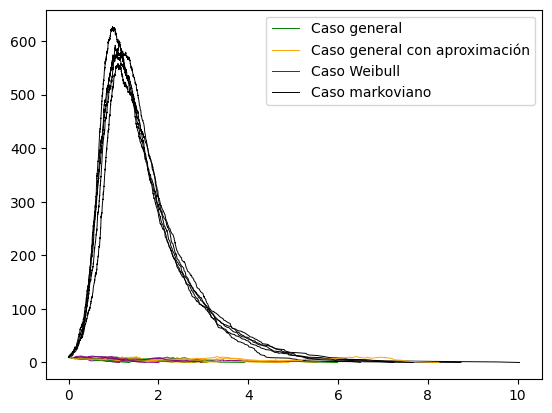

--- 11.031195640563965 Segundos en promedio para ejecutar 1 iteracion del general ---
--- 10.139186906814576 Segundos en promedio para ejecutar 1 iteracion del general usando aproximacion---
--- 10.503163528442382 Segundos en promedio para ejecutar 1 iteracion del caso Weibull ---
--- 0.8401622295379638 Segundos en promedio para ejecutar 1 iteracion del caso markoviano ---


In [3]:
import time
start_time = time.time()
N=10**3
n=int(N*0.1)
ksum=1
np.random.seed(2)
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.configuration_model(k_dist)
G = nx.Graph(G)#Remover multi-aristas
G.remove_edges_from(nx.selfloop_edges(G))#Remover bucles
pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=int(0.01*N),replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
beta=75
gamma=1
a_I=2.0
a_R=1.5
import math
lammbda_I=(beta/N)/math.gamma(1+1/a_I)
lammbda_R=gamma/math.gamma(1+1/a_R)
def psi_survival_infection(x):
    return np.exp(-(lammbda_I*x)**(a_I))
def psi_survival_recovery(x):
    return np.exp(-(lammbda_R*x)**(a_R))
def psi_infection(x):
    return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
def psi_recovery(x):
    return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))

times_general=[]
times_general_approx=[]
times_weibull=[]
times_markovian=[]
picos={"gen":[],"genApprox":[],"weib":[],"mark":[]}
for k in range(5):
    #------------------------------------ General
    iter_time = time.time()
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Non_Markovian_Network(densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,approx=False,approx_lim=0.05,T=np.inf)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.7,label='Caso general ')
    else:
        plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['gen'].append([H['time'][i],H['I(t)'][i]])
    times_general.append((time.time() - iter_time))
    #------------------------------------
    #------------------------------------ General aproximado
    iter_time = time.time()
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Non_Markovian_Network(densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,approx=True,approx_lim=0.1,T=np.inf)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'orange',linewidth=0.7,label='Caso general con aproximación')
    else:
        plt.plot(H['time'],H['I(t)'], 'orange',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['genApprox'].append([H['time'][i],H['I(t)'][i]])
    times_general_approx.append((time.time() - iter_time))
    #------------------------------------
    #------------------------------------ Weibull
    iter_time = time.time()
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Non_Markovian_Network(params=[a_I,a_R,lammbda_I,lammbda_R],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,approx=False,approx_lim=0.05,T=np.inf)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'purple',linewidth=0.7,label='Caso Weibull')
    else:
        plt.plot(H['time'],H['I(t)'], 'purple',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['weib'].append([H['time'][i],H['I(t)'][i]])
    times_weibull.append((time.time() - iter_time))
    #------------------------------------
    #------------------------------------ Markoviano
    iter_time = time.time()
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'black',linewidth=0.7,label='Caso markoviano')
    else:
        plt.plot(H['time'],H['I(t)'], 'black',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['mark'].append([H['time'][i],H['I(t)'][i]])
    times_markovian.append((time.time() - iter_time))
    #------------------------------------
plt.legend()
plt.show()
print("--- %s Segundos en promedio para ejecutar 1 iteracion del general ---" %np.mean(times_general))
print("--- %s Segundos en promedio para ejecutar 1 iteracion del general usando aproximacion---" %np.mean(times_general_approx))
print("--- %s Segundos en promedio para ejecutar 1 iteracion del caso Weibull ---" % np.mean(times_weibull))
print("--- %s Segundos en promedio para ejecutar 1 iteracion del caso markoviano ---" % np.mean(times_markovian))

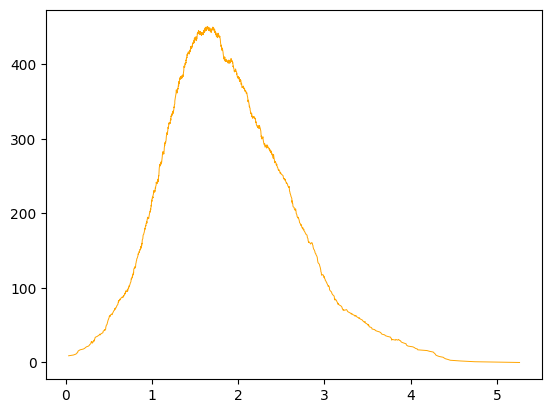

In [9]:
beta=75
gamma=1
a_I=1.2
a_R=1.5
import math
lammbda_I=(beta/N)/math.gamma(1+1/a_I)
lammbda_R=gamma/math.gamma(1+1/a_R)
G_copy=G.copy()
X_I_indexes_copy=X_I_indexes.copy()
H=Gillespie_Direct_Method_Non_Markovian_Network(densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,approx=True,approx_lim=0.1,T=np.inf)
plt.plot(H['time'],H['I(t)'], 'orange',linewidth=0.7,label='Caso general con aproximación')

In [ ]:
plt.savefig("final.png", )

<Figure size 640x480 with 0 Axes>

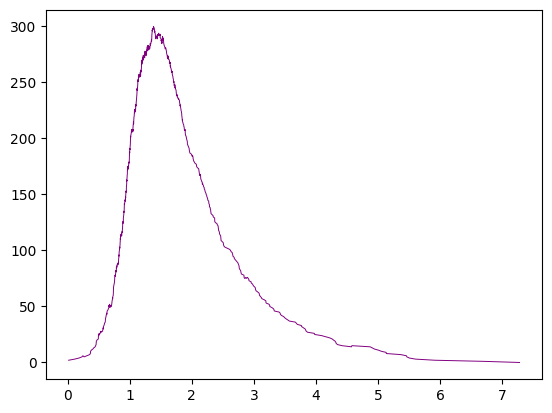

In [55]:
beta=75
gamma=1
a_I=1.0
a_R=1.0
import math
lammbda_I=(beta/N)/math.gamma(1+1/a_I)
lammbda_R=gamma/math.gamma(1+1/a_R)
G_copy=G.copy()
X_I_indexes_copy=X_I_indexes.copy()
H=Gillespie_Direct_Method_Non_Markovian_Network(params=[a_I,a_R,lammbda_I,lammbda_R],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,approx=False,approx_lim=0.05,T=np.inf)
plt.plot(H['time'],H['I(t)'], 'purple',linewidth=0.7,label='Caso Weibull')

In [ ]:
picos

{'gen': [[1.3676232920817246, 367],
  [1.240534007152062, 398],
  [1.2903900374634525, 381],
  [1.3708813249436518, 397],
  [1.443139024740364, 396]],
 'genApprox': [[1.2194573377952218, 401],
  [1.2915036578641408, 393],
  [1.4950020386139262, 387],
  [1.353198238887414, 399],
  [1.3470687188924553, 384]],
 'weib': [[1.2913683916354521, 413],
  [1.2594575262922383, 406],
  [1.300494782992104, 406],
  [1.506782678887545, 382],
  [1.4316985263608386, 385]],
 'mark': [[0.1639944586188669, 465],
  [0.2413169395380354, 455],
  [0.18738874927631766, 459],
  [0.22248961610761253, 472],
  [0.16952995398242704, 450]]}

Grafica de convergencia del caso markoviano

Empieza
Tomó 0.534358024597168s. para 5 iteraciones con N=100
Empieza
Tomó 5.772881507873535s. para 5 iteraciones con N=1000
Empieza
Tomó 450.0582945346832s. para 5 iteraciones con N=10000


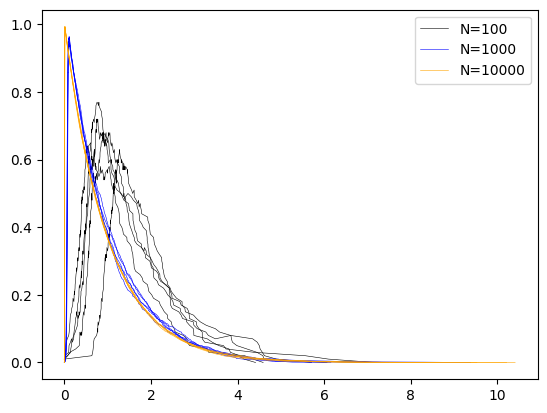

In [ ]:
import time
colores=['blue','orange','black']
for pot in [2,3,4]:
    iter_time = time.time()
    beta=1.15
    gamma=1
    N=10**pot
    n=int(N*0.1)
    ksum=1
    np.random.seed(2)
    G=nx.fast_gnp_random_graph(n=N, p=0.1, seed=None, directed=False)
    #pos=nx.spring_layout(G,seed=2,k=3)
    np.random.seed(0)
    X_I_indexes=[0]
    for k in range(N):
        if k in X_I_indexes:
            G.nodes[k]['Estado:']='Infeccioso'
        else:
            G.nodes[k]['Estado:']='Susceptible'
    print("Empieza")
    #------------------------------------ Markoviano
    for iter in range(5):
        H=[]
        while(len(H)<10):
            G_copy=G.copy()
            X_I_indexes_copy=X_I_indexes.copy()
            H=Gillespie_Direct_Method_Network(beta/N,gamma,N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
        if(iter==0):
            plt.plot(H['time'],H['I(t)']/N, colores[pot-2],linewidth=0.4,label='N='+str(N))
        else:
            plt.plot(H['time'],H['I(t)']/N, colores[pot-2],linewidth=0.4)
        #------------------------------------
    print("Tomó "+str(time.time()-iter_time)+'s. para 5 iteraciones con N='+str(N))
plt.legend()
plt.show()

In [ ]:
plt.savefig('compr_m.png')

<Figure size 640x480 with 0 Axes>